# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

### Jacob J. Bukoski

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text says, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should respond by printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [1]:
import pyaudio
import wave
import time
from ipywidgets import widgets, interact
from IPython.display import display
from pyaudio import paInt16

class recorder(object):
    
    def __init__(self, fname, channels=1, rate=16000, chunk=1024, mode='wb'):
        self.fname = fname
        self.channels = channels
        self.rate = rate
        self.chunk = chunk
        self.mode = mode
        self._stream = None
        self.format = pyaudio.paInt16
        self._pa = pyaudio.PyAudio()
        self.wavefile = self._prepare_file(self.fname, self.mode)
    
    def start_recording(self):
        self._stream = self._pa.open(format=self.format,
                   channels=self.channels,
                   rate=self.rate,
                   input=True,
                   frames_per_buffer=self.chunk,
                   stream_callback=self.get_callback())
        
        self._stream.start_stream()
        return self
    
    def stop_recording(self):
        self._stream.stop_stream()
        return self
        
    def get_callback(self):
        def callback(in_data, frame_count, time_info, status):
            self.wavefile.writeframes(in_data)
            return in_data, pyaudio.paContinue
        return callback
    
    def close(self):
        self._stream.close()
        self._pa.terminate()
        self.wavefile.close()
        
    def _prepare_file(self, fname, mode='wb'):
        wavefile = wave.open(fname, mode)
        wavefile.setnchannels(self.channels)
        wavefile.setsampwidth(self._pa.get_sample_size(pyaudio.paInt16))
        wavefile.setframerate(self.rate)
        return wavefile

# Instantiate the recorder class    

recording = False
recorded_message = recorder('message.wav')
        
# Set up the recorder button function

def rec_button(btn):
    
    global recording
    
    if not recording:
        recording = True
        print("Recording -- say something to record a message.")
        recorded_message.start_recording()
        
    else:
        recording = False
        print("Done recording.")
        recorded_message.stop_recording()
        recorded_message.close()      

# Set up the button
    
button = widgets.Button(
            description="Click to record a message")

button.layout.width = '100%'
button.on_click(rec_button)
display(button)


Recording -- say something to record a message.
Done recording.


In [3]:
## Write a function to send an audio file to Houndify's server and receive an annotated string

import houndify

def transcribe(filename):

    buffer=512
    finished=False
    result = None
    
    cl_ID = 'nHfyi3gOj3SeeWfSvl42dA=='
    cl_Key = 'g8uL9F7lthu-IuPfUT8A1_VgkFufyUXBMH7q2I869fuxkXj4dtAmcVKs_WddF1QC36uo2aSwJGPQjbUx7mz2uw=='
    user_ID = 'test_user'
    client = houndify.StreamingHoundClient(cl_ID, cl_Key, user_ID)

    class MyListener(houndify.HoundListener):
        """HoundListener is a class that defines callbacks that can be received 
        while streaming speech to the server:
    
        onPartialTranscript: server has partial transcript in live transcription mode; transcript is 
            the string with the partial transcription
    
        onFinalResponse: server has completed processing query and has response; response is JSON 
            object (python dictionary) that server sends back
        
        onTranslatedResponse: fired if server requested to JSON response to external API; contains raw 
            data from external translation API
        
        onError: fires error if connection with server fails
    
        """
        def onPartialTranscript(self, transcript):
            #print("Partial transcript: " + transcript)
            nonlocal result
            result = transcript
        
    audio = wave.open(filename)  # Opens the audio file using the 'wave' module
    frameRate = audio.getframerate()   # Determines the frameRate from the Audio, should be 8000 or 16000
    client.setSampleRate(frameRate)    # Sets the SampleRate as the files frame rate
    frames = audio.readframes(buffer)  

    finished = False
    
    client.start(MyListener())  # Creates connection to server and  prepares streaming

    while not finished:     
        finished = client.fill(frames)    # fill() sends PCM samples to server
        frames = audio.readframes(buffer)    # rewrite frames to identify stop
        if len(frames) == 0:    
            break
    client.finish()    # finalizes transaction with server, waits for data to be received

    return result

# Send the audio file to Houndify and receive a transcript back

transcript = transcribe('message.wav')
print(transcript)   # Check the transcription


hello this is a recording test


In [4]:
## Set up a program to send the result of the above function to an email server and receive a reply

import inflect
import smtplib
import os
import operator
import json
import ast
from urllib.request import urlopen
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders
from email.utils import COMMASPACE, formatdate

## Code for function to convert number words into numerals is borrowed from:
## http://stackoverflow.com/questions/493174/is-there-a-way-to-convert-number-words-to-integers

nums = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen", "twenty"]

def text2int(textnum, numwords={}):
    if not numwords:
      units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
      ]

      tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

      scales = ["hundred", "thousand", "million", "billion", "trillion"]

      numwords["and"] = (1, 0)
      for idx, word in enumerate(units):    numwords[word] = (1, idx)
      for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
      for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
          raise Exception("Illegal word: " + word)

        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

## Set up an actions function to determine what is in the message command, and apply the appropriate action
## per the command.

class actions(object):
    '''This function provides three actions depending on the text that is input to it.''' 
    
    def __init__(self, message):
        self.message = message
    
    def calculate(self):
        split_string = self.message.split()
        self.formula = None
        
        ops = {'plus' : operator.add, 'minus' : operator.sub, 'times' : operator.mul, 
               'divided' : operator.truediv}
        
        # Need to add 'divided by' functionality.
        
        calc_ind = split_string.index("calculate")
        first_num = split_string[calc_ind+1]
        last_num = split_string[-1]
        
        for i in range(len(split_string)):
            for key in ops:
                if key == split_string[i]:
                    op = split_string[i]
                    
        self.formula = ops.get(op)(text2int(first_num), text2int(last_num))
        return self.formula
                
    def email(self):
        with open('pwd') as f: 
            for x in f.readlines():
                password = x.strip()
        
        split_string = self.message.split()
        
        subj_ind = split_string.index("subject")
        body_ind = split_string.index("body")
        
        for i in range(len(split_string)):
            subj = ' '.join(split_string[subj_ind+1:body_ind])
    
        for i in range(len(split_string)):
            body = ' '.join(split_string[body_ind+1:])
        
        def mail(sender, pwd, to, subject, text, files=[]):
            msg = MIMEMultipart()
            msg["From"] = sender
            msg["To"] = COMMASPACE.join(to)
            msg["Date"] = formatdate(localtime=True)
            msg["Subject"] = subject
            msg.attach(MIMEText(text))
            for file in files:
                part = MIMEBase("application", "octet-stream")
                part.set_payload( open(file,"rb").read() )
                Encoders.encode_base64(part)
                part.add_header("Content-Disposition", "attachment; filename='%s'"
                       % os.path.basename(file))
                msg.attach(part)
            # Note that we need to designate the remote SMTP server we want to use.
            mailServer = smtplib.SMTP("smtp.gmail.com", 587)
            mailServer.starttls()
            mailServer.login(sender, pwd)
            mailServer.sendmail(sender, to, msg.as_string())
            mailServer.close()

        mail(sender="jbukoski1@gmail.com", 
            pwd=password, 
            to=["jbukoski@berkeley.edu",],   # include an extra comma in the "to" list to 
                                   # account for the COMMASPACE.join(to)
            subject=subj, 
            text=body)
        
        print("Email sent!")

    def joke(self):
             
        full_json = urlopen("http://api.icndb.com/jokes/random").read()
        test=full_json.decode('UTF-8')
        test_dict = eval(test)
        print(test_dict['value']['joke'])
        
    def command(self):
        if "email me" in self.message:
            print("Command: %s \nSending email..." % self.message)
            self.email()
        elif "joke" in self.message:
            print("Command: %s \nFetching joke..." % self.message)
            self.joke()
        elif "calculate" in self.message:
            print("Command: %s \nCalculating..." % self.message)
            print("The answer is: %s" %self.calculate())
        else:
            print('no action taken')
    
## Test the function    
    
test = actions(transcript)
test.command()


no action taken




# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [6]:
# Write a program that identifies musical notes from sound files

%matplotlib inline

import pyaudio
import wave
import aifc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
from numpy.fft import rfft

class analyze_freqs(object):
    
    def __init__(self, file):
        self.file = file
        self.audio = aifc.open("./sound_files/%s" %file)
        self.frames = self.audio.getnframes()
        self.channels = self.audio.getnchannels()
        self.rate = self.audio.getframerate()
        self.data = self.audio.readframes(self.frames)
        self.integer_data = sp.fromstring(self.data, dtype=np.int32)

    def get_periodogram(self):
        self.f, self.Pxx_dens = signal.periodogram(self.integer_data, self.rate)
        
    def decompose_audio(self):
        self.audioFFT = np.fft.rfft(self.integer_data)
        self.audioAmp = np.abs(self.audioFFT)
        self.audioPower = np.abs(self.audioFFT)**2
        self.audioPhase = np.angle(self.audioFFT)
        self.audioFreqs = np.fft.fftfreq(self.audioFFT.size, 1 / self.rate)
        self.audioIdx = np.argsort(self.audioFreqs)
        self.audioFreqsIdx = self.audioFreqs[self.audioIdx]
        self.audioPowerIdx = self.audioPower[self.audioIdx]
               
    def get_dom_freqs(self, pwrLvl=1e+25):
        '''Distance function to identify steps in frequency and average all values within each step'''
        self.pwrLvl = pwrLvl
        self.mostPowerfulFreqs = self.audioFreqsIdx[np.where(self.audioPowerIdx > pwrLvl)]
        self.mostPowerfulFreqs = self.mostPowerfulFreqs[np.where(self.mostPowerfulFreqs > 0)]
        
        self.steps = np.array([j-i for i, j in zip(self.mostPowerfulFreqs[:-1], self.mostPowerfulFreqs[1:])])

        self.steps = np.where(self.steps > 20)
        self.steps = [x+1 for x in self.steps]

        self.steps = np.insert(self.steps, 0, 0)
        self.steps = np.append(self.steps, len(self.mostPowerfulFreqs))

        self.freqs = []

        for i in range(1, len(self.steps)):
            self.freqs.append(np.mean(self.mostPowerfulFreqs[self.steps[i-1]:self.steps[i]]))

        self.domFreqs = np.around(self.freqs,2)

        return self.domFreqs
    
    def pwrSpec_fig(self):
        pwr_fig = plt.figure(figsize=(7,4.5))
        pwr_fig.ax1 = pwr_fig.add_subplot(1,1,1)
        pwr_fig.ax1.plot(self.audioFreqsIdx, self.audioPowerIdx)
        pwr_fig.ax1.set_xlim([0,20000])
        pwr_fig.ax1.set_xlabel('Frequency (hz)')
        pwr_fig.ax1.set_ylabel('Power')
        plt.figtext(.5,0.95, 'Power frequency spectrum for file: %s' %self.file, fontsize=14, ha='center')
        
    def step_fig(self):
        step_fig = plt.figure(figsize=(7,4.5))
        step_ax1 = step_fig.add_subplot(1,1,1)
        step_ax1.plot(self.mostPowerfulFreqs)
        step_ax1.set_ylabel("Frequency (hz)")
        plt.figtext(.5,1,'Dominant frequencies for file: %s' %self.file, fontsize=14, ha='center')
        plt.figtext(.5,0.95,'A power cutoff level of %s was used' %self.pwrLvl, fontsize=10, ha='center')

    
    
##======================================================    
## Initiate the class and extract the dominant_freqs

test = analyze_freqs('10.aif')
test.decompose_audio()
domFreqs = test.get_dom_freqs(pwrLvl=1e+25)

print("The dominant frequencies of file '%s', in no particular order, are: %s, %s & %s" 
      %(test.file, domFreqs[0], domFreqs[1], domFreqs[2]))


The dominant frequencies of file '10.aif', in no particular order, are: 520.29, 782.52 & 2089.66


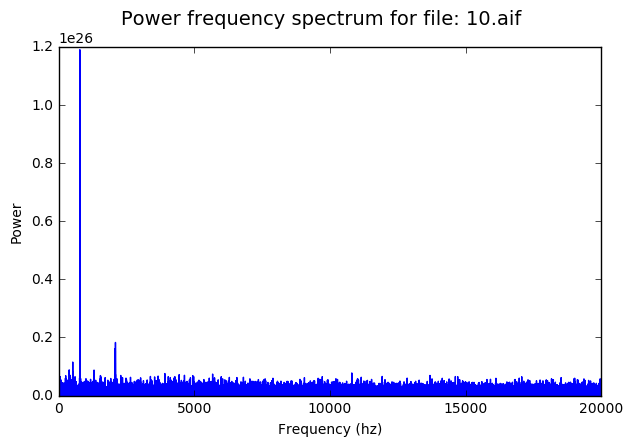

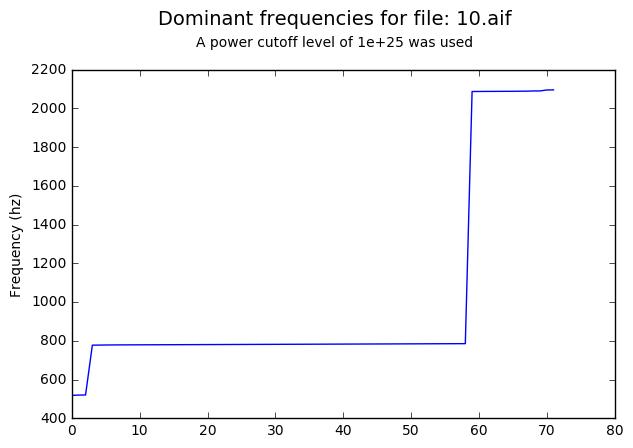

In [7]:
# Generate some descriptive plots of the data

# This figure displays the frequencies associated with the highest power. We can use the power level cutoff
# in the analyze_freqs.get_dom_freqs(pwrLvl=) call to adjust the number of steps that are considered. I set 
# 1e+25 as the default, which I determined to be appropriate for most plots.

test.pwrSpec_fig()

test.step_fig()

